In [168]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import control as ctl
import joblib

In [169]:
dt = 0.050

# IMPORTANDO MODELO

In [170]:
def getModel():
    size = 10
    path = r'../System/model.pkl'
    return size, joblib.load(path)


size, model = getModel()
model

LinearRegression()

In [171]:
class StatesUpdater:
    buffer  = None
    initial = 0
    size    = 0

    def __init__(self, size, initial=0):
        self.initial = initial
        self.size    = size
        self.buffer  = initial * np.ones(size)
    
    def update(self, value=None):
        for i in range(self.size-1, 0, -1):
            self.buffer[i] = self.buffer[i-1]
        
        self.setFirst(value)
        return self.buffer
    
    def setFirst(self, value):
        if value is not None:
            self.buffer[0] = value

    def reset(self):
        for i in range(self.size): self.buffer[i] = self.initial


states = StatesUpdater(3)
for i in range(1, 5): print(states.update(i))

[1. 0. 0.]
[2. 1. 0.]
[3. 2. 1.]
[4. 3. 2.]


In [172]:
import warnings

class System:
    def __init__(self, size, model, initial=0):
        warnings.filterwarnings('ignore', category=UserWarning)
        self.states = StatesUpdater(size, initial) 
        self.model  = model

    def update(self, input):
        xData = np.array([self.states.update(input)])
        return self.model.predict(xData)[0]
    
    def reset(self):
        self.states.reset()
    

system = System(size, model)

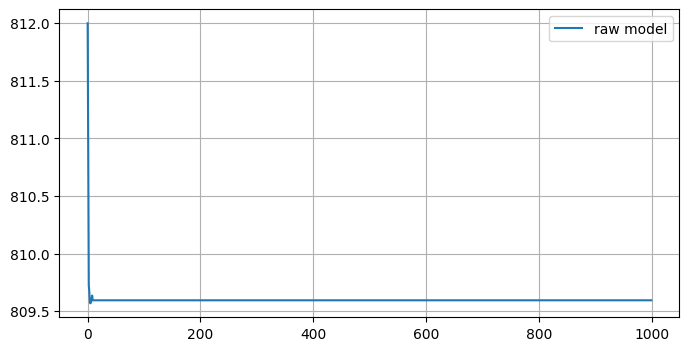

In [173]:
yModel = [system.update(1) for i in range(1000)]
plt.figure(figsize=(8, 4))
plt.plot(yModel, label='raw model')
plt.legend(), plt.grid()
plt.show()

# RESPOSTA DESEJADA

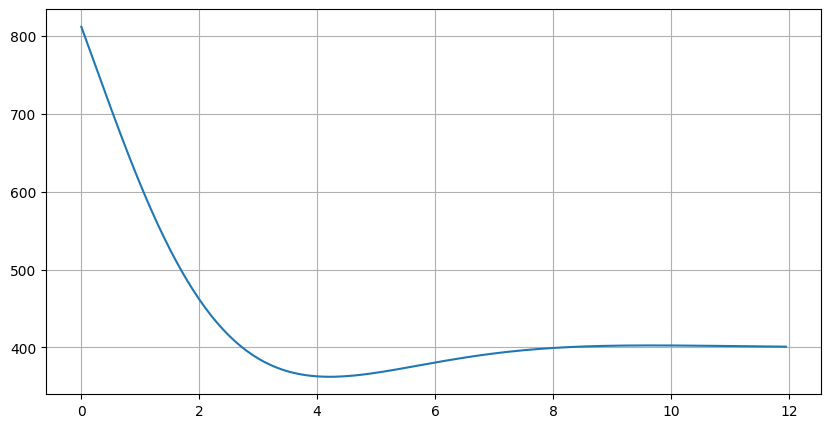

In [174]:
def getResponse(x, A, Yo, Ts, UP):
    return (A - Yo)*(-np.e**(-4/Ts*x)*np.cos(10*1.151563*UP*x) + 1) + Yo

setpoint = 400
initial  = yModel[0]
Ts = 8.0
UP = 0.05

time    = np.arange(0, 1.5*Ts, dt)
uData   = setpoint * np.ones_like(time)
desired = np.array([getResponse(t, setpoint, initial, Ts, UP) for t in time])

plt.figure(figsize=(10, 5))
plt.plot(time, desired)
plt.grid()

# DEFININDO CONTROLADOR

In [175]:
class Controller:
    def __init__(self, dt=0.05, bounds=None, coefs=[]):
        self.bounds = bounds if bounds is not None else (-9e12, 9e12)
        self.dt    = dt
        self.coefs = coefs
        self.Xn  = StatesUpdater(size=5)
        self.Yn  = StatesUpdater(size=5)
        
    def control(self, input, setpoint):
        error = (setpoint - input)
        self.Xn.update(error)
        self.Yn.update()

        a, b, c, d, e, f = self.coefs

        Xn, Yn = self.Xn.buffer, self.Yn.buffer
        out = -(Xn[0]*a + Xn[1]*b + Xn[2]*c + Yn[1]*d + Yn[2]*e) + f

        if out > self.bounds[1]:
            out = self.bounds[1]
        
        if out < self.bounds[0]:
            out = self.bounds[0]

        self.Yn.setFirst(out)
        return out
    
    def reset(self):
        self.Xn.reset(), self.Yn.reset()


controller = Controller(dt, coefs=[1, 2, 3, 4, 5])

# MALHA FECHADA

In [176]:
class Feedback:
    def __init__(self, system, controller, dt):
        self.system     = system
        self.controller = controller
        self.dt = dt
        self.reset()
    
    def predict(self, input, setpoint):
        Y = self.controller.control(input, setpoint)
        X = self.system.update(Y)
        return X, Y
    
    def simulate(self, uData):
        xData  = np.zeros_like(uData)
        yData  = np.zeros_like(uData)
        output = uData[0]

        for i, setpoint in enumerate(uData):
            X, Y = self.predict(output, setpoint)
            xData[i] = X
            yData[i] = Y
            output = X

        return xData, yData
    
    def simulateResponse(self, uData):
        xData  = np.zeros_like(uData)
        output = uData[0]

        for i, setpoint in enumerate(uData):
            output   = self.predict(output, setpoint)[0]
            xData[i] = output
        
        return xData
    
    def reset(self):
        self.system.reset(), self.controller.reset()


feedback = Feedback(system, controller, dt)
feedback.controller.bounds = (-1000, 1000)

# CURVE FIT

In [177]:
from scipy.optimize import curve_fit, OptimizeWarning
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=OptimizeWarning)

In [178]:
def curveFit(function, xData, yData, maxIter=2100000000):
    coefs = curve_fit(function, xData, yData, maxfev=maxIter, method='lm') # 'lm', 'trf', 'dogbox'
    return [round(coef, 12) for coef in list(coefs[0])]

def getControl(uData, a, b, c, d, e, f):
    controller.coefs = [a, b, c, d, e, f]
    feedback.reset()
    #for i in range(100): system.update(1)
    return feedback.simulateResponse(uData)


controller.coefs = curveFit(getControl, xData=uData, yData=desired)
controller.coefs

[np.float64(-0.03474354884),
 np.float64(0.016879515599),
 np.float64(-0.003264137535),
 np.float64(-1.959582088942),
 np.float64(1.009097799813),
 np.float64(8.956388790504)]

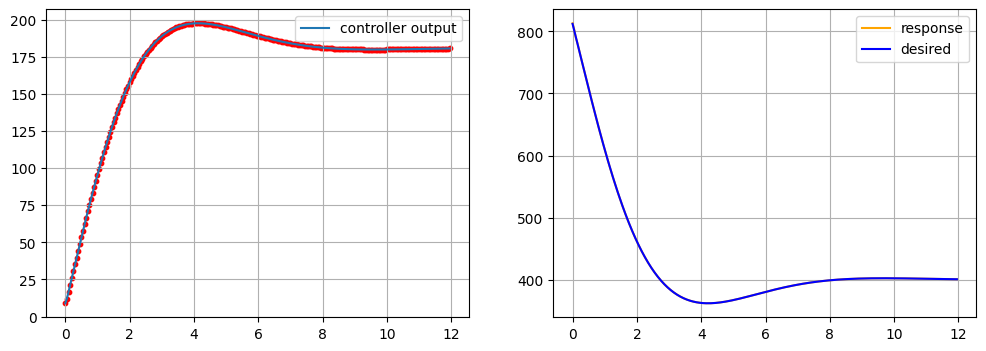

In [179]:
feedback = Feedback(system, controller, dt)
response, output = feedback.simulate(uData)

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(time, output, label='controller output')
plt.scatter(time, output, s=10, color='red')
plt.grid(), plt.legend()
plt.subplot(1, 2, 2)
plt.plot(time, response, color='orange', label='response')
plt.plot(time, desired, color='blue', label='desired')
plt.grid(), plt.legend()
plt.show()